# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Tensor

### Reverse-mode autodiff

In [2]:
x = Tensor(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

45.0
62.0


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ data {n.data} | grad {n.grad} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

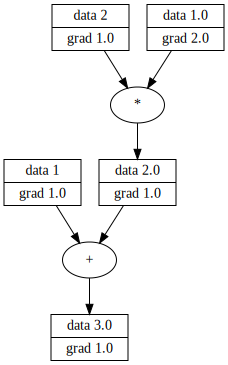

In [4]:
x = Tensor(1.0)
y = (x * 2 + 1)
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2)
print(n)
print(n.parameters())

None Neuron(2)
[Tensor(data=[0.23550571 0.06653115], grad=[0. 0.]), Tensor(data=0, grad=0.0)]


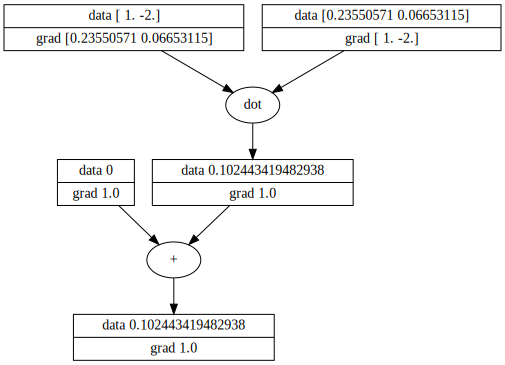

In [6]:
n.zero_grad()
x = Tensor([1.0, -2.0])
y = n(x)
y.backward()
draw_dot(y)

### Learning XOR

In [7]:
from pyfit.engine import Tensor

inputs = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
print(inputs)
targets = [Tensor(0), Tensor(1), Tensor(1), Tensor(0)]

Tensor(data=[[0 0]
 [0 1]
 [1 0]
 [1 1]], grad=[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]])


In [8]:
from pyfit.nn import MLP, Layer

model = MLP()
model.add(Layer(2, 4, activation='sigmoid'))
model.add(Layer(4, 1, activation='sigmoid'))
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of <function sigmoid at 0x7f2598d9f0d0> Neurons(2), Layer of <function sigmoid at 0x7f2598d9f0d0> Neurons(4)]
Number of parameters: 4


In [9]:
from pyfit.optim import SGD
from pyfit.loss import mean_squared_error

optimizer = SGD(model.parameters(), learning_rate=0.1)
loss = mean_squared_error

for epoch in range(5):
    # Reset the gradients of model parameters
    optimizer.zero_grad()
    epoch_loss = Tensor(0)
    for i in range(len(inputs)):
        # Forward pass
        output = model(inputs[i])
        # Loss computation
        batch_loss = loss(output, targets[i])
        epoch_loss += batch_loss
        # Backprop and gradient descent
        batch_loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, loss = {batch_loss.data}")
    #print(model.parameters())

Exception: bad shapes: () and (4,)